# Insurance Cost Prediction Using Linear Regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [0]:
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

## Step 1: Download and Explore the Data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [0]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [0]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [0]:
your_name =  # ??? at least 5 characters

In [0]:
ord(your_name[0])

120

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [0]:
def customize_dataset(dataframe_raw, rand_str):
    # Make a copy
    dataframe = dataframe_raw.copy(deep=True)
    # Drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [0]:
dataframe_raw

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [0]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe

,age,sex,bmi,children,smoker,region,charges
1246,45,female,26.98500,3,no,southwest,8828.744060
488,44,female,39.96300,0,yes,southeast,47418.581542
95,28,female,39.50100,1,no,southeast,3653.877286
343,63,male,38.60325,0,no,northeast,13562.394840
1025,21,female,36.33000,0,no,southwest,1959.571690
...,...,...,...,...,...,...,...
430,19,male,34.75500,0,no,southwest,22390.466670
641,42,male,29.72550,3,yes,northwest,31803.834832
1081,32,male,29.22675,1,no,northwest,4320.770570
715,60,male,30.34500,0,no,southwest,11782.561870


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [0]:
num_rows = # ???
print(num_rows)

1271


**Q: How many columns does the dataset have**

In [0]:
num_cols =  # ???
print(num_cols)

7


**Q: What are the column titles of the input variables?**

In [0]:
input_cols = # [???]

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [0]:
categorical_cols = # [???]

**Q: What are the column titles of output/target variable(s)?**

In [0]:
output_cols =  # [???]

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [0]:
import numpy as np

In [0]:
# Write your answer here
print(min(dataframe.charges))
print(max(dataframe.charges))
np.mean(dataframe.charges)

1088.217683
61857.3151697


12907.167713479954

In [0]:
print(dataframe.charges.min())
print(dataframe.charges.max())
print(dataframe.charges.mean())

1088.217683
61857.3151697
12907.167713479954


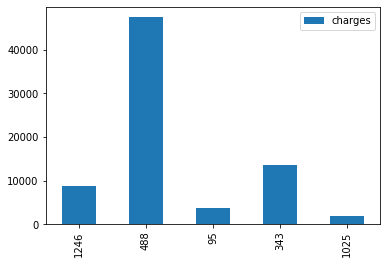

In [0]:
dataframe[0:5].plot(kind='bar',y='charges')
plt.show()

## Step 2: Prepare the Dataset for Training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [0]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [0]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[4.50000000e+01, 0.00000000e+00, 2.69850000e+01, ...,
         0.00000000e+00, 3.00000000e+00, 8.82874406e+03],
        [4.40000000e+01, 0.00000000e+00, 3.99630000e+01, ...,
         1.00000000e+00, 2.00000000e+00, 4.74185815e+04],
        [2.80000000e+01, 0.00000000e+00, 3.95010000e+01, ...,
         0.00000000e+00, 2.00000000e+00, 3.65387729e+03],
        ...,
        [3.20000000e+01, 1.00000000e+00, 2.92267500e+01, ...,
         0.00000000e+00, 1.00000000e+00, 4.32077057e+03],
        [6.00000000e+01, 1.00000000e+00, 3.03450000e+01, ...,
         0.00000000e+00, 3.00000000e+00, 1.17825619e+04],
        [5.90000000e+01, 0.00000000e+00, 3.37050000e+01, ...,
         0.00000000e+00, 3.00000000e+00, 1.35870053e+04]]),
 array([[ 8828.74406  ],
        [47418.5815417],
        [ 3653.877286 ],
        ...,
        [ 4320.7705705],
        [11782.56187  ],
        [13587.00534  ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [0]:
inputs =  # ???
targets = # ???

In [0]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [0]:
inputs.shape

torch.Size([1271, 7])

In [0]:
dataframe.values.shape

(1271, 7)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [0]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [0]:
val_percent =  # ??? between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [0]:
batch_size =  # ???

In [0]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [0]:
for xb, yb in train_loader:
    print("inputs:", xb.shape)
    print("targets:", yb.shape)
    break

inputs: torch.Size([128, 7])
targets: torch.Size([128, 1])


## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [0]:
input_size = len(input_cols)
output_size = len(output_cols)

In [0]:
model=nn.Linear(input_size, output_size)
model(xb).shape

torch.Size([128, 1])

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [0]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear =  # ??? fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out =  # ??? fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss =  # ??? fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss =  # ??? fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [0]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [0]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.1536, -0.3545,  0.3345, -0.1943, -0.2368,  0.0548, -0.1578]],
        requires_grad=True), Parameter containing:
 tensor([-0.1017], requires_grad=True)]

## Step 4: Train the Model to Fit the Data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [0]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [0]:
result =  # ??? Use the the evaluate function
print(result)

{'val_loss': 22006.58203125}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [0]:
epochs = # ???
lr = # ???
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 1695118.7500
Epoch [40], val_loss: 2555701.5000
Epoch [50], val_loss: 2691728.5000


In [0]:
epochs =  # ???
lr = # ???
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 272393.4688
Epoch [40], val_loss: 220212.5938
Epoch [60], val_loss: 116908.8281


In [0]:
epochs =  # ???
lr =  # ???
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 11759.8203
Epoch [40], val_loss: 21776.7812
Epoch [60], val_loss: 9022.3691
Epoch [70], val_loss: 946.2640


In [0]:
epochs = # ???
lr = # ???
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 2367.8076
Epoch [40], val_loss: 1258.1040
Epoch [60], val_loss: 583.1664
Epoch [80], val_loss: 1864.7175


In [0]:
epochs = # ???
lr = # ???
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 227.0931
Epoch [40], val_loss: 57.5910
Epoch [60], val_loss: 54.1295
Epoch [80], val_loss: 5.8404


**Q: What is the final validation loss of your model?**

In [0]:
val_loss =  # ???

## Step 5: Make Predictions Using the Trained Model

**Q: Complete the following function definition to make predictions on a single input**

In [0]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions =  # ??? fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [0]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([6.2000e+01, 0.0000e+00, 4.1160e+01, 0.0000e+00, 0.0000e+00, 3.0000e+00,
        1.3067e+04])
Target: tensor([13066.7344])
Prediction: tensor([13061.6230])


In [0]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([4.0000e+01, 0.0000e+00, 2.3331e+01, 2.0000e+00, 1.0000e+00, 2.0000e+00,
        1.8861e+04])
Target: tensor([18860.9375])
Prediction: tensor([18854.6562])


In [0]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([4.8000e+01, 0.0000e+00, 2.8728e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        9.1640e+03])
Target: tensor([9163.9609])
Prediction: tensor([9159.8613])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try Another Dataset & Blog about It

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931